# Columns/Variable Definitions:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.shape

(6362620, 11)

In [7]:
fraud=df.copy()

step


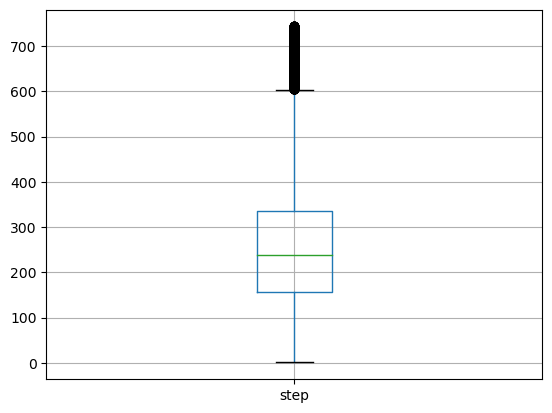

amount


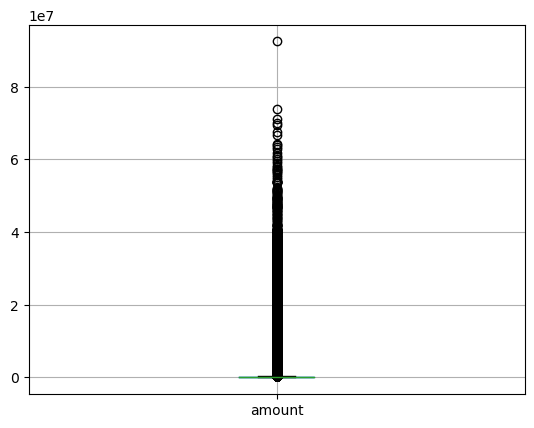

oldbalanceOrg


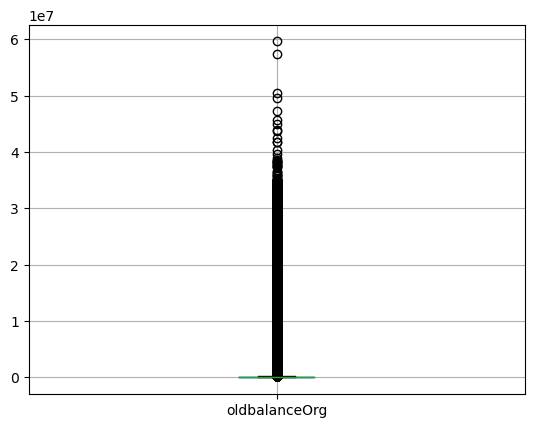

newbalanceOrig


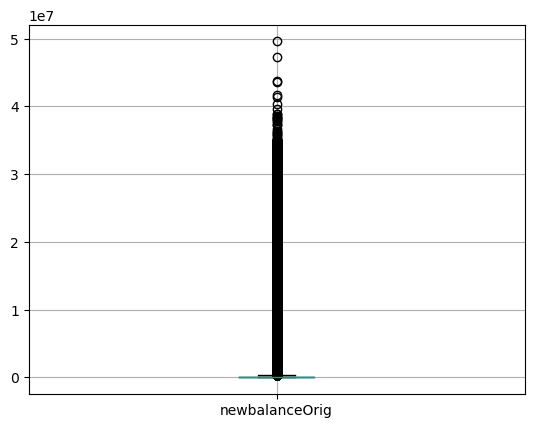

oldbalanceDest


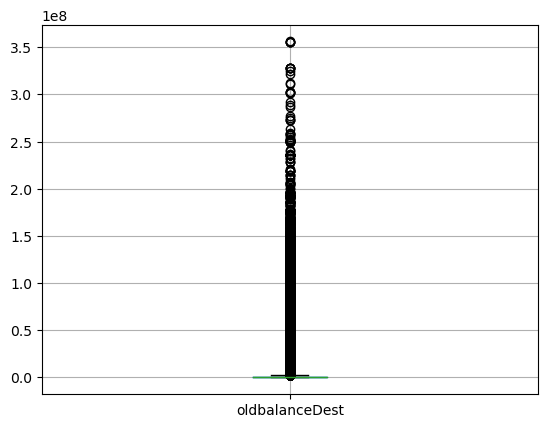

newbalanceDest


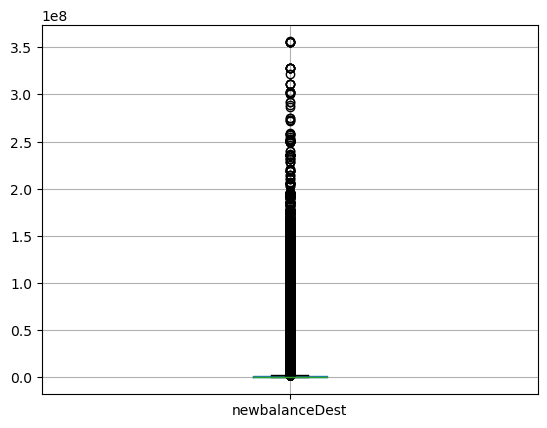

isFraud


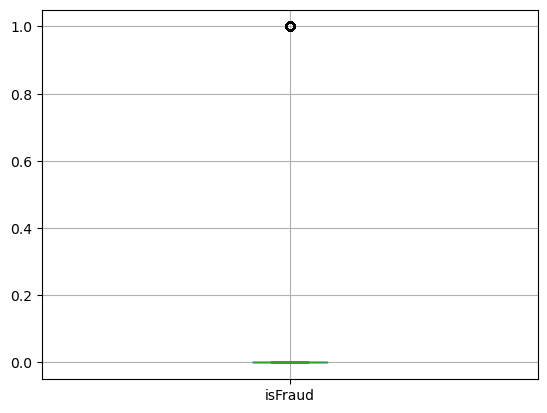

isFlaggedFraud


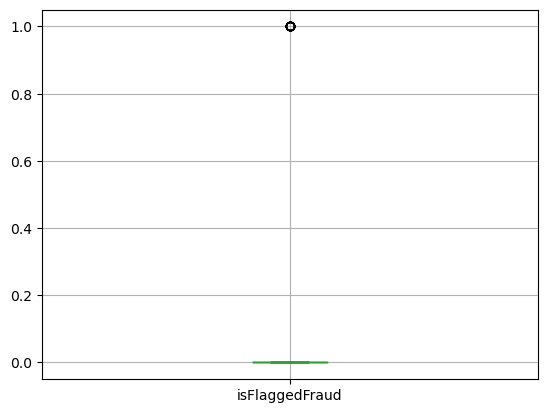

In [14]:
for col in fraud.columns:
    if fraud[col].dtype=='float64' or fraud[col].dtype=='int64':
        print(col)
        fraud.boxplot(column=col)
        plt.show()
    
    
    

we can say the step column have some outliers and can't conclude much about other columns.

In [10]:
numerical_columns=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
outliers_count={}
for col in numerical_columns:
    Q1 = fraud[col].quantile(0.25)
    Q3 = fraud[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((fraud[col] < (Q1 - 1.5 * IQR)) |
                (fraud[col] > (Q3 + 1.5 * IQR)))
    
    
    num_outliers = outliers.sum()
    outliers_count[col] = num_outliers
    
for col, count in outliers_count.items():
    print(f"Number of outliers in column '{col}': {count}")

Number of outliers in column 'step': 102688
Number of outliers in column 'amount': 338078
Number of outliers in column 'oldbalanceOrg': 1112507
Number of outliers in column 'newbalanceOrig': 1053391
Number of outliers in column 'oldbalanceDest': 786135
Number of outliers in column 'newbalanceDest': 738527


In [15]:
fraud['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [16]:
fraud.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

# Finding Correlation Between The Features

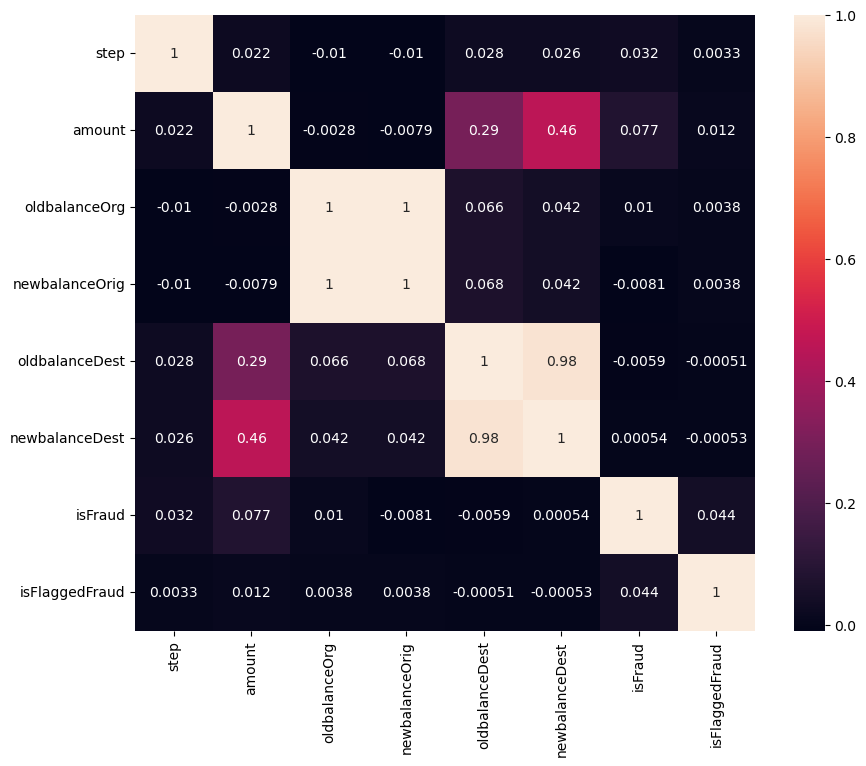

In [20]:
correlation_matrix = fraud.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Calculating New balance columns from existing Ones


In [21]:
fraud['balanceChangeOrig'] = fraud['newbalanceOrig'] - fraud['oldbalanceOrg']
fraud['balanceChangeDest'] = fraud['newbalanceDest'] - fraud['oldbalanceDest']
fraud.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1, inplace=True)

In [24]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFraud',
       'isFlaggedFraud', 'balanceChangeOrig', 'balanceChangeDest'],
      dtype='object')

In [25]:
fraud.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

# Using one hot-encoding converting categorical columns to numerical


In [26]:
onehot = pd.get_dummies(fraud['type'], prefix='type')
df = pd.concat([fraud, onehot], axis=1)
df.drop(['type'], axis=1, inplace=True)

In [27]:
df.head()

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,balanceChangeOrig,balanceChangeDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,M1979787155,0,0,-9839.64,0.0,0,0,0,1,0
1,1,1864.28,C1666544295,M2044282225,0,0,-1864.28,0.0,0,0,0,1,0
2,1,181.00,C1305486145,C553264065,1,0,-181.00,0.0,0,0,0,0,1
3,1,181.00,C840083671,C38997010,1,0,-181.00,-21182.0,0,1,0,0,0
4,1,11668.14,C2048537720,M1230701703,0,0,-11668.14,0.0,0,0,0,1,0


In [33]:
df.nameDest.value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

In [32]:
df.nameOrig.value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['nameOrig'] = labelencoder.fit_transform(df['nameOrig'])
df['nameDest'] = labelencoder.fit_transform(df['nameDest'])

In [37]:
df.head()

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,balanceChangeOrig,balanceChangeDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,1662094,0,0,-9839.64,0.0,0,0,0,1,0
1,1,1864.28,2188998,1733924,0,0,-1864.28,0.0,0,0,0,1,0
2,1,181.00,1002156,439685,1,0,-181.00,0.0,0,0,0,0,1
3,1,181.00,5828262,391696,1,0,-181.00,-21182.0,0,1,0,0,0
4,1,11668.14,3445981,828919,0,0,-11668.14,0.0,0,0,0,1,0


In [38]:
from sklearn.model_selection import train_test_split
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [56]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the model: {accuracy * 100:.2f}%')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


Accuracy of the model: 99.93%
Confusion Matrix:
[[1270842      83]
 [    842     757]]


In [47]:
model_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('modelDT', DecisionTreeClassifier(random_state=2))

DecisionTreeClassifier(random_state=2)

In [49]:
y_pred=model_dt.predict(X_test_scaled)

In [55]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the model: {accuracy * 100:.2f}%')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy of the model: 99.94%
Confusion Matrix:
[[1270536     389]
 [    367    1232]]


In [52]:
feature_importances = model_dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

              Feature  Importance
5   balanceChangeOrig    0.385084
6   balanceChangeDest    0.234515
0                step    0.133094
11      type_TRANSFER    0.078275
2            nameOrig    0.050206
3            nameDest    0.048341
1              amount    0.040827
8       type_CASH_OUT    0.027687
4      isFlaggedFraud    0.001815
10       type_PAYMENT    0.000155
7        type_CASH_IN    0.000000
9          type_DEBIT    0.000000
